In [46]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

Specify file path and create target variable

In [47]:
# Use when in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = "/content/drive/MyDrive/Datasets for Google Colab/student_success_enhanced.csv"
# df = pd.read_csv(file_path)


# Use when in local environment
# file_path = "./student_success_enhanced.csv"
# df = pd.read_csv(file_path)


# Use when in Shared Google Colab
file_id = '17eoOjbTriXdOnuUC2LSHDe-9lA-V_h1X'
url = f'https://drive.google.com/uc?id={file_id}'

# Send GET request to download the file
response = requests.get(url)

# Use io.BytesIO to read the content into pandas directly
df = pd.read_csv(io.BytesIO(response.content))

# Create target variable column, "Graduated" based on Graduation_Rate
df['Graduated'] = (df['Graduation_Rate'] >= 0.6).astype(int)

In [48]:
# Setup columns that need to be scaled or encoded
numerical_columns = ["GPA", "SAT_Score", "ACT_Score", "Family_Size", "Support_Center_Utilization",
                     "Retention_Rate", "Graduation_Age", "Study_Hours_Per_Week", "Student_Loan_Amount", "Distance_From_Home", "Work_Hours_Per_Week"]
nominal_columns = ["Marital_Status", "Life_Event", "Major"]
ordinal_columns = ["Income_Level", "Institution_Type", "Campus_Engagement", "First_Gen_Student", "Enrollment_Status"]

Displaying the split between "Graduated" 1 and 0

In [49]:
df['Graduated'].value_counts()

Graduated
1    7159
0    2841
Name: count, dtype: int64

Display the dataset and information

In [50]:
# Show the first couple rows of the dataframe
df.head(13)

,Student_ID,GPA,SAT_Score,ACT_Score,Family_Size,Income_Level,Marital_Status,Support_Center_Utilization,Retention_Rate,Graduation_Rate,...,Graduation_Age,Major,Study_Hours_Per_Week,Student_Loan_Amount,Campus_Engagement,First_Gen_Student,Enrollment_Status,Distance_From_Home,Work_Hours_Per_Week,Graduated
0,1,2.73,1174,26,1,High,Married,0.23,0.72,0.62,...,22.3,STEM,13.3,30968.51,Low,False,Full-Time,42.0,16.9,1
1,2,2.61,1079,24,4,High,Married,0.15,0.68,0.63,...,23.0,STEM,25.1,18679.95,Low,True,Full-Time,5.0,4.4,1
2,3,2.81,1197,26,4,Low,Married,0.47,0.61,0.58,...,22.4,Education,15.1,39004.41,Low,False,Full-Time,62.9,9.5,0
3,4,3.35,1328,29,1,High,Divorced,0.00,0.90,0.90,...,22.5,STEM,13.1,15563.23,Low,False,Full-Time,93.1,4.2,1
4,5,3.02,1064,23,1,Middle,Single,0.22,0.61,0.66,...,22.9,Arts,21.8,6533.81,Low,False,Full-Time,63.1,15.5,1
5,6,2.43,1064,23,1,Middle,Divorced,0.26,0.54,0.58,...,22.5,STEM,13.0,28718.06,Medium,False,Full-Time,64.8,14.7,0
6,7,3.64,1336,30,4,Low,Single,0.28,0.71,0.65,...,22.0,Arts,17.1,21571.52,Low,False,Full-Time,65.2,8.7,1
7,8,2.80,1215,27,1,Low,Single,0.36,0.86,0.84,...,23.0,Health Sciences,15.3,8249.42,High,False,Full-Time,95.8,8.9,1
8,9,2.32,1029,23,1,Middle,Single,0.56,0.56,0.56,...,23.1,Arts,15.7,19196.86,Low,False,Part-Time,65.8,8.3,0
9,10,3.20,1181,26,1,Middle,Married,0.37,1.00,0.99,...,22.0,Business,3.1,16445.08,Medium,False,Full-Time,90.8,14.4,1


In [51]:
# Display the unique values within a specific column
df['Life_Event'].unique()
# df['Income_Level'].value_counts()

array(['Family Issues', nan, 'Health Issues', 'Financial Problems'],
      dtype=object)

In [52]:
# Describe the different values of a specific column
df['Family_Size'].describe()

count    10000.000000
mean         2.120700
std          1.232268
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: Family_Size, dtype: float64

In [53]:
# Replacing missing values in the Life_Event column with 'None'
df['Life_Event'] = df['Life_Event'].fillna('None')
# Display the unique values within a specific column
df['Life_Event'].unique()

array(['Family Issues', 'None', 'Health Issues', 'Financial Problems'],
      dtype=object)

In [54]:
# Prepare data
X = df.drop(columns=["Student_ID", "Graduation_Rate", "Graduated"])
y = df["Graduated"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 6700
Number of testing samples: 3300


In [55]:
# One-hot encode categorical (nominal) variables
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)

# Apply the same encoding to the test set
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Handle categorical (ordinal) columns
le = LabelEncoder()
for col in ordinal_columns:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [56]:
print(X_train.shape)
print(X_test.shape)

(6700, 25)
(3300, 25)


In [57]:
X_train.head()

,GPA,SAT_Score,ACT_Score,Family_Size,Income_Level,Support_Center_Utilization,Retention_Rate,Institution_Type,Graduation_Age,Study_Hours_Per_Week,...,Work_Hours_Per_Week,Marital_Status_Married,Marital_Status_Single,Life_Event_Financial Problems,Life_Event_Health Issues,Life_Event_None,Major_Business,Major_Education,Major_Health Sciences,Major_STEM
8371,2.21,962,21,3,1,0.42,0.57,1,23.2,17.9,...,12.8,False,True,False,False,True,False,False,False,False
5027,2.81,1033,23,2,2,0.73,0.70,1,22.3,12.9,...,5.3,True,False,False,True,False,True,False,False,False
9234,3.24,1276,28,2,0,0.00,0.77,1,22.0,13.0,...,12.9,False,False,False,False,True,False,False,True,False
3944,2.34,1038,23,4,1,0.59,0.81,0,22.9,10.3,...,11.3,True,False,False,False,True,False,False,True,False
6862,3.51,1390,31,1,1,0.11,0.89,1,22.6,17.3,...,12.5,False,True,False,False,True,False,False,False,True


In [58]:
# Display the unique values within a specific column
X_train['Life_Event_None'].unique()
# df['Income_Level'].value_counts()

array([ True, False])

Converting boolean values into 1s and 0s

In [59]:
# Convert only boolean columns (True/False) to 1/0
boolean_columns = X_train.select_dtypes(include=['bool']).columns
X_train[boolean_columns] = X_train[boolean_columns].astype(int)
X_test[boolean_columns] = X_test[boolean_columns].astype(int)

# LOGISTIC REGRESSION

In [60]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Train logistic regression model
model = LogisticRegression(max_iter=2000, solver='saga')
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

In [61]:
# Evaluate model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

# Print results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Training Accuracy: 0.9095522388059701
Test Accuracy: 0.9081818181818182
Confusion Matrix:
 [[ 791  162]
 [ 141 2206]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       953
           1       0.93      0.94      0.94      2347

    accuracy                           0.91      3300
   macro avg       0.89      0.88      0.89      3300
weighted avg       0.91      0.91      0.91      3300



In [62]:
print(f"Predicted Class Distribution: {np.bincount(y_test_pred)}")

Predicted Class Distribution: [ 932 2368]


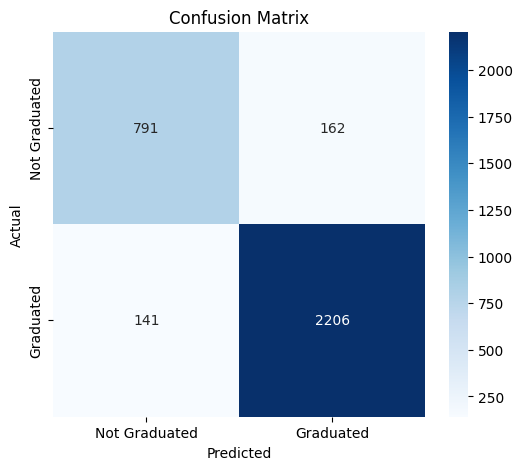

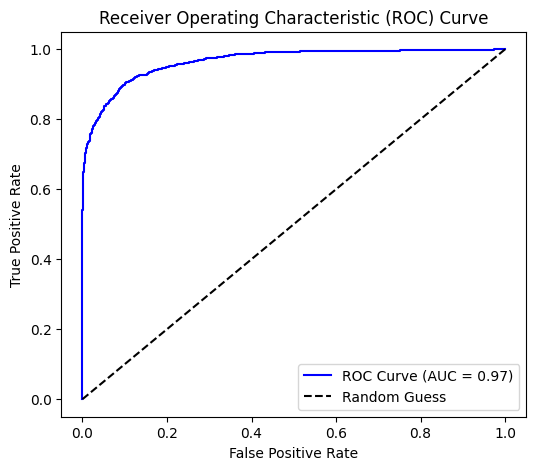

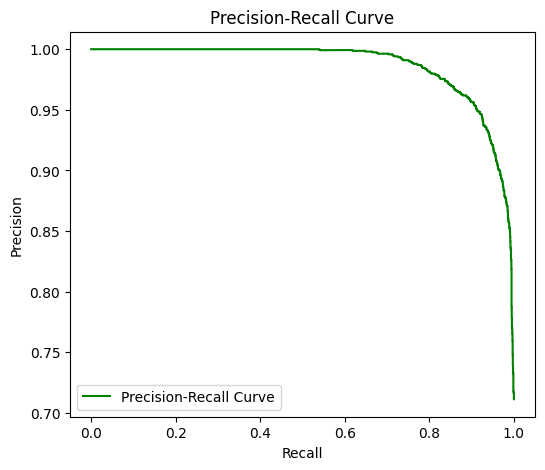

In [63]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Precision-Recall Curve (with zero_division parameter)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# DECISION FOREST


In [64]:
model = DecisionTreeClassifier(random_state=42,max_depth=4)
# When using Decision Trees, we do not want to scale the data.
# model.fit(X_train_scaled, y_train)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

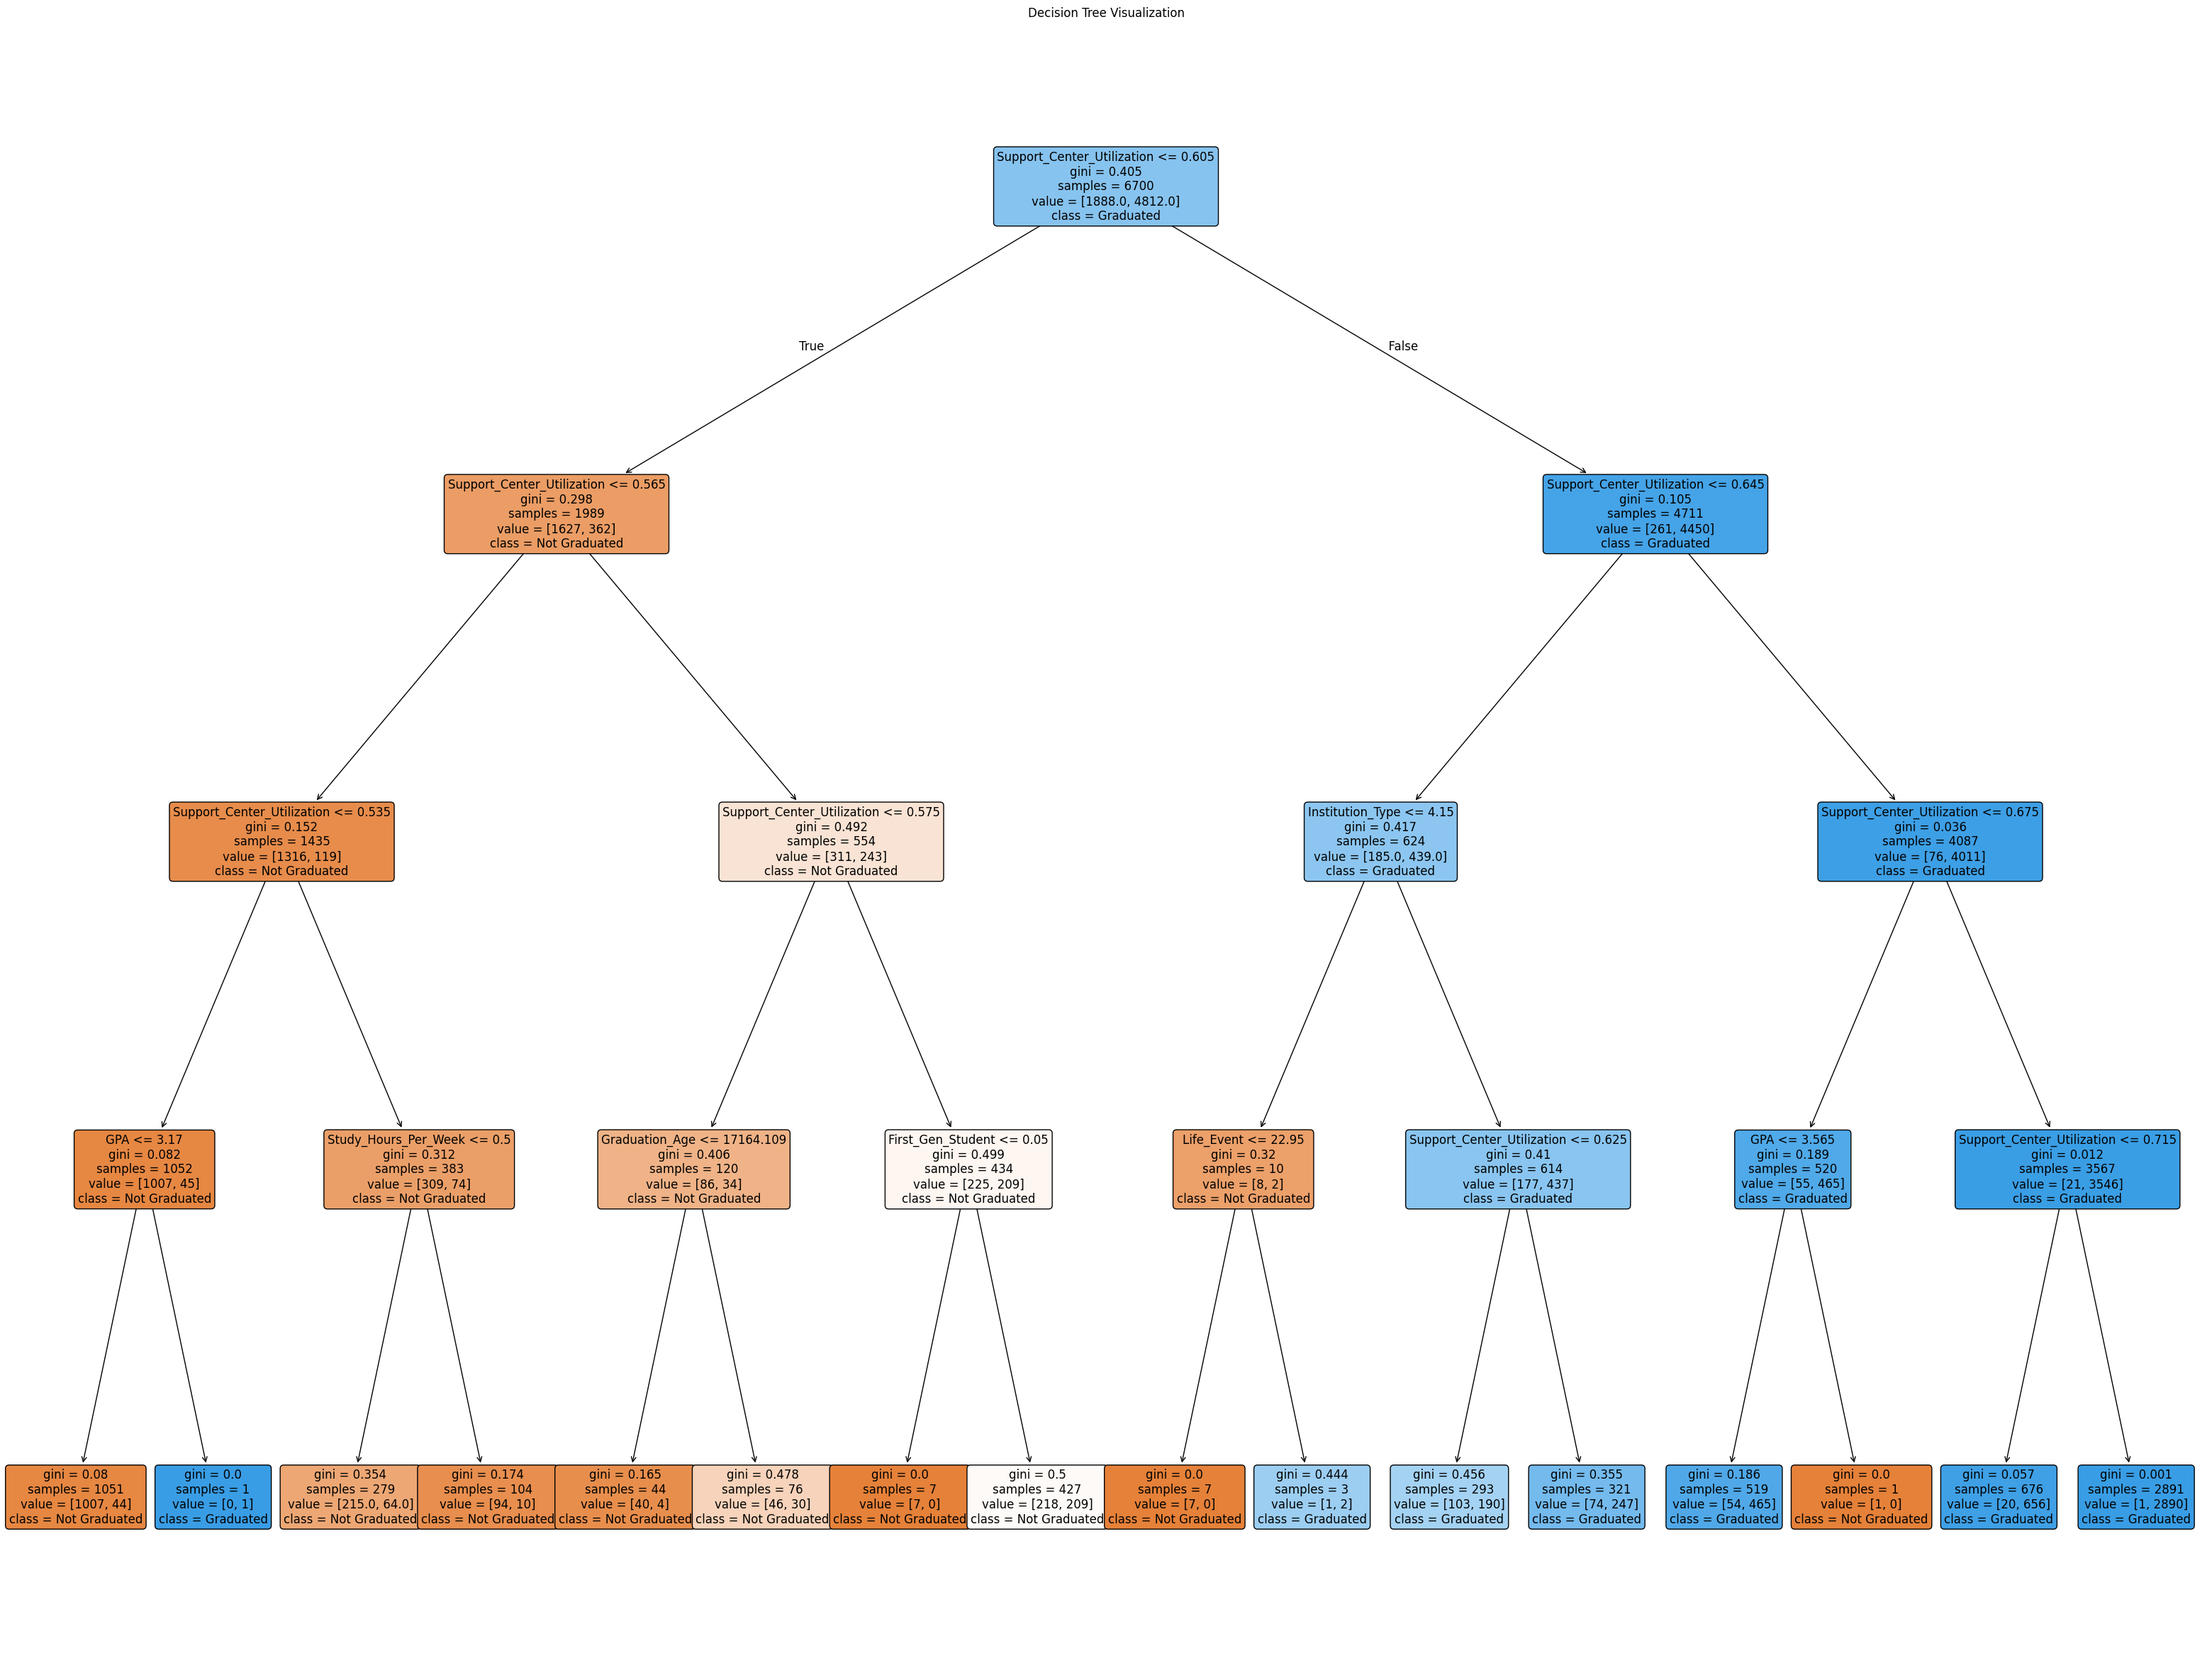

In [65]:
from sklearn.tree import plot_tree

# Plot the trained decision tree
plt.figure(figsize=(40, 30))
plot_tree(model, filled=True, feature_names=X.columns, class_names=["Not Graduated", "Graduated"], rounded=True, fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

In [66]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print(f"Predicted Class Distribution: {np.bincount(y_test_pred)}")


Training Accuracy: 0.9083582089552239
Test Accuracy: 0.9051515151515152
Confusion Matrix:
 [[ 818  135]
 [ 178 2169]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       953
           1       0.94      0.92      0.93      2347

    accuracy                           0.91      3300
   macro avg       0.88      0.89      0.89      3300
weighted avg       0.91      0.91      0.91      3300

Predicted Class Distribution: [ 996 2304]


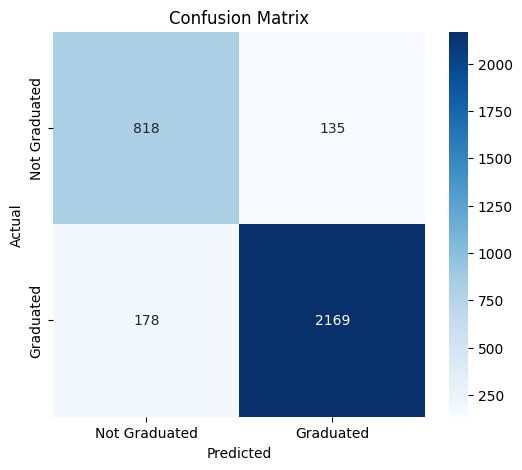

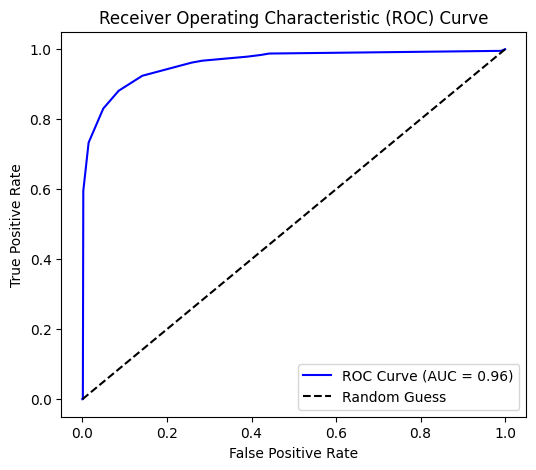

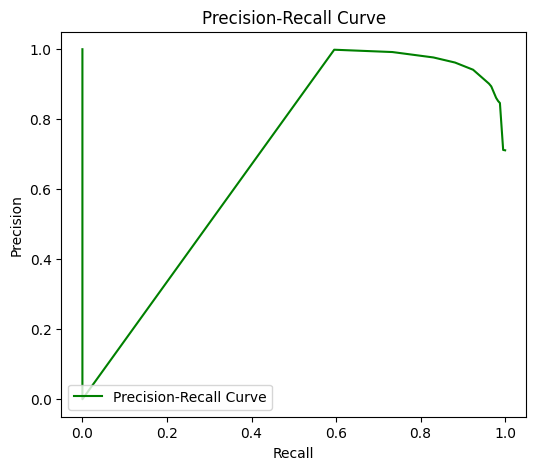

In [67]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Precision-Recall Curve (with zero_division parameter)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# RANDOM FOREST

In [68]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 90.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       953
           1       0.93      0.94      0.93      2347

    accuracy                           0.91      3300
   macro avg       0.89      0.88      0.89      3300
weighted avg       0.91      0.91      0.91      3300



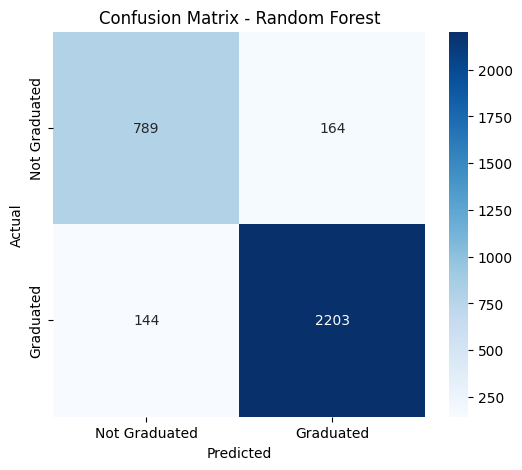

In [70]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset (assuming df is your DataFrame and you've already preprocessed it)
# Assuming your target is 'Graduation_Rate' (converted to 0 or 1 for classification)

'''
# Prepare features and target
X = df.drop(columns=['Student_ID', 'Graduation_Rate'])  # Dropping ID and target column
y = df['Graduation_Rate'].apply(lambda x: 1 if x >= 0.5 else 0)  # Binary target (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
'''

# Initialize the base model (Decision Tree as the weak learner for AdaBoost)
base_model = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost with the base model
ada_boost = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=42)

# Fit the AdaBoost model
ada_boost.fit(X_train, y_train)

# Predict on test data
y_pred = ada_boost.predict(X_test)
y_pred_proba = ada_boost.predict_proba(X_test)[:, 1]

# Model Evaluation

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve using Plotly
fig_roc = go.Figure()

fig_roc.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC Curve (AUC = {roc_auc:.2f})',
    line=dict(color='#FF6347', width=3)  # Tomato red color
))

fig_roc.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name="Random Guess",
    line=dict(color='#D3D3D3', dash='dash', width=2)  # Light gray for random guess
))

fig_roc.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig_roc.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall curve using Plotly
fig_prc = go.Figure()

fig_prc.add_trace(go.Scatter(
    x=recall,
    y=precision,
    mode='lines',
    name="Precision-Recall Curve",
    line=dict(color='#32CD32', width=3)  # Lime green color
))

fig_prc.update_layout(
    title="Precision-Recall Curve",
    xaxis_title="Recall",
    yaxis_title="Precision",
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig_prc.show()

# Confusion Matrix Heatmap
fig_cm = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=["Not Graduated", "Graduated"],
    y=["Not Graduated", "Graduated"],
    colorscale='RdBu',  # Red-Blue color scale for better contrast
    showscale=True
)

fig_cm.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted",
    yaxis_title="Actual",
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Not Graduated", "Graduated"]),
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Not Graduated", "Graduated"]),
)

fig_cm.show()
